In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

In [3]:
import itertools
from sklearn.model_selection import KFold

In [4]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes
from segmentation import reach_segment_sabes
from decoders import lr_decode_windowed

In [5]:
start_times = {'indy_20160426_01': 0,
               'indy_20160622_01':1700,
               'indy_20160624_03': 500,
               'indy_20160627_01': 0,
               'indy_20160630_01': 0,
               'indy_20160915_01': 0,
               'indy_20160921_01': 0,
               'indy_20160930_02': 0,
               'indy_20160930_05': 300,
               'indy_20161005_06': 0,
               'indy_20161006_02': 350,
               'indy_20161007_02': 950,
               'indy_20161011_03': 0,
               'indy_20161013_03': 0,
               'indy_20161014_04': 0,
               'indy_20161017_02': 0,
               'indy_20161024_03': 0,
               'indy_20161025_04': 0,
               'indy_20161026_03': 0,
               'indy_20161027_03': 500,
               'indy_20161206_02': 5500,
               'indy_20161207_02': 0,
               'indy_20161212_02': 0,
               'indy_20161220_02': 0,
               'indy_20170123_02': 0,
               'indy_20170124_01': 0,
               'indy_20170127_03': 0,
               'indy_20170131_02': 0,
               }


### Initial windowing

In [6]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df1 = pickle.load(f)
with open('/home/akumar/nse/neural_control/data/sabes_decoding_sf.dat', 'rb') as f:
    sabes_df2 = pickle.load(f)

In [9]:
sabes_df2.iloc[0]['dimreduc_args']

{'T': 3, 'loss_type': 'trace', 'n_init': 10}

In [8]:
sabes_df2 = pd.DataFrame(sabes_df2)

In [6]:
# Approach (1): Calculate decoder on segmented version of the time series
# Approach (2): Use whole series decoder and measure its performance on different segmentations of the time series

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'data_file', 'decoder', 'decoder_args', 'decoder_obj', 'r2'],
      dtype='object')

In [1]:
# Looking at Approach 2

In [15]:
sabes_df.iloc[2000]['decoder_args']

{'trainlag': 4, 'testlag': 4, 'decoding_window': 5}

In [32]:
dimvals

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [94]:
data_files = np.unique(sabes_df1['data_file'].values)
folds = np.arange(5)
#dimvals = np.unique(sabes_df1['dim'].values)[0:21]
dimvals = np.array([2, 6, 10, 15, 20])

# Pick one
windows = [(0, 20), (-10, 10), (-5, 5), (0, 10), (0, 30), (-20, 20), (-20, 0), (20, 30), (10, 20)]
lag = 4

wr2 = np.zeros((len(data_files), folds.size, dimvals.size, len(windows), 2, 6))

for i, data_file in enumerate(data_files):
    
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])
    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']
    for f, fold in enumerate(folds):
        for d, dimval in tqdm(enumerate(dimvals)):

            df1 = apply_df_filters(sabes_df1, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=dimval)
            df2 = apply_df_filters(sabes_df2, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dimval,
                                    dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})

            assert(df1.shape[0] == 1)
            assert(df2.shape[0] == 1)

            assert(np.all(df1.iloc[0]['train_idxs'] == df2.iloc[0]['train_idxs']))
            assert(np.all(df1.iloc[0]['test_idxs'] == df2.iloc[0]['test_idxs']))

            xpca = X @ df1.iloc[0]['coef'][:, 0:dimval]
            xfcca = X @ df2.iloc[0]['coef']

            # Apply projection
            for j, window in enumerate(windows):
                r2pos, r2vel, r2acc, r2post, r2velt, r2acct, _ = lr_decode_windowed(xpca, Z, lag, window, dat['transition_times'],
                                                            df1.iloc[0]['train_idxs'], df1.iloc[0]['test_idxs'], decoding_window=5) 
                wr2[i, f, d, j, 0, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
                r2pos, r2vel, r2acc, r2post, r2velt, r2acct, _ = lr_decode_windowed(xfcca, Z, lag, window, dat['transition_times'],
                                                            df1.iloc[0]['train_idxs'], df1.iloc[0]['test_idxs'], decoding_window=5)
                wr2[i, f, d, j, 1, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.39s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [02:38, 31.66s/it]
5it [02:51, 34.34s/it]
5it [02:46, 33.30s/it]
5it [02:42, 32.41s/it]
5it [02:38, 31.70s/it]


Processing spikes


100%|██████████| 1/1 [00:19<00:00, 19.93s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [04:33, 54.61s/it]
5it [04:40, 56.15s/it]
5it [04:38, 55.69s/it]
5it [04:27, 53.46s/it]
5it [04:18, 51.69s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:20,  4.10s/it]
5it [00:21,  4.31s/it]
5it [00:21,  4.26s/it]
5it [00:20,  4.14s/it]
5it [00:20,  4.09s/it]


Processing spikes


100%|██████████| 1/1 [00:27<00:00, 27.59s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [14:27, 173.49s/it]
5it [15:19, 183.91s/it]
5it [15:01, 180.23s/it]
5it [14:27, 173.43s/it]
5it [14:17, 171.41s/it]


Processing spikes


100%|██████████| 1/1 [00:11<00:00, 11.98s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [02:45, 33.14s/it]
5it [02:55, 35.15s/it]
5it [02:53, 34.72s/it]
5it [02:49, 33.93s/it]
5it [02:46, 33.39s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:13,  2.67s/it]
5it [00:14,  2.86s/it]
5it [00:13,  2.78s/it]
5it [00:13,  2.75s/it]
5it [00:13,  2.67s/it]


Processing spikes


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:12,  2.48s/it]
5it [00:13,  2.68s/it]
5it [00:13,  2.63s/it]
5it [00:12,  2.57s/it]
5it [00:12,  2.48s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:17,  3.51s/it]
5it [00:19,  3.80s/it]
5it [00:18,  3.70s/it]
5it [00:18,  3.60s/it]
5it [00:17,  3.52s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.26s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:14,  2.81s/it]
5it [00:14,  2.99s/it]
5it [00:14,  2.93s/it]
5it [00:14,  2.87s/it]
5it [00:14,  2.82s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.09s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:12,  2.57s/it]
5it [00:13,  2.79s/it]
5it [00:13,  2.72s/it]
5it [00:13,  2.66s/it]
5it [00:12,  2.57s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.13s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:20,  4.11s/it]
5it [00:21,  4.30s/it]
5it [00:21,  4.25s/it]
5it [00:20,  4.15s/it]
5it [00:20,  4.02s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:18,  3.71s/it]
5it [00:19,  3.91s/it]
5it [00:18,  3.79s/it]
5it [00:18,  3.72s/it]
5it [00:18,  3.65s/it]


Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.51s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:30,  6.16s/it]
5it [00:32,  6.41s/it]
5it [00:31,  6.37s/it]
5it [00:31,  6.22s/it]
5it [00:30,  6.08s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.26s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:23,  4.68s/it]
5it [00:24,  4.94s/it]
5it [00:24,  4.89s/it]
5it [00:24,  4.85s/it]
5it [00:23,  4.67s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.20s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:23,  4.74s/it]
5it [00:25,  5.11s/it]
5it [00:25,  5.03s/it]
5it [00:24,  4.85s/it]
5it [00:23,  4.73s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.00s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:22,  4.50s/it]
5it [00:23,  4.80s/it]
5it [00:23,  4.72s/it]
5it [00:23,  4.63s/it]
5it [00:22,  4.48s/it]


Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.89s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:21,  4.27s/it]
5it [00:22,  4.55s/it]
5it [00:22,  4.46s/it]
5it [00:22,  4.40s/it]
5it [00:21,  4.29s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.16s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:23,  4.65s/it]
5it [00:24,  4.97s/it]
5it [00:24,  4.83s/it]
5it [00:23,  4.75s/it]
5it [00:23,  4.68s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.08s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:22,  4.52s/it]
5it [00:24,  4.82s/it]
5it [00:23,  4.72s/it]
5it [00:23,  4.62s/it]
5it [00:22,  4.54s/it]


Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:26,  5.34s/it]
5it [00:27,  5.56s/it]
5it [00:27,  5.53s/it]
5it [00:26,  5.36s/it]
5it [00:26,  5.22s/it]


Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.97s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
0it [00:00, ?it/s]


ValueError: need at least one array to concatenate

In [39]:
np.savez('windowed_r2.npy', wr2)

In [40]:
len(windows)

7

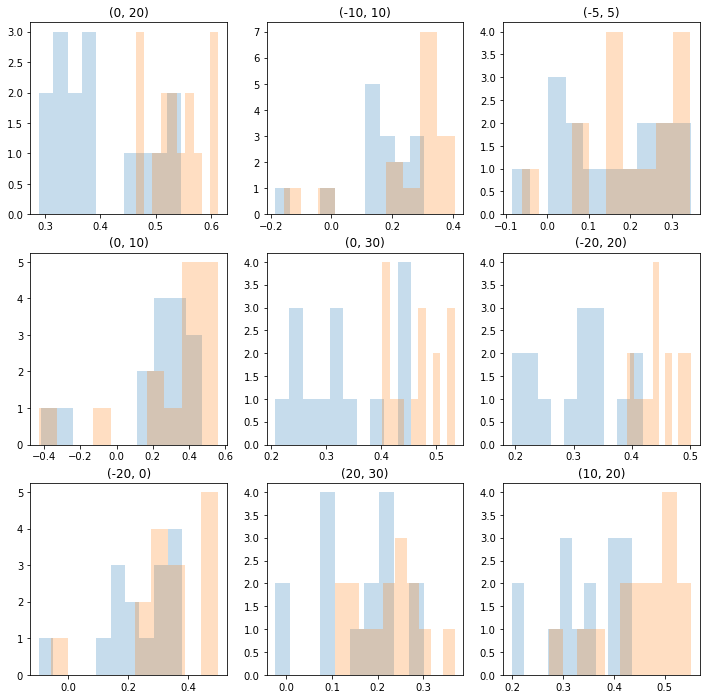

In [79]:
# Plot histogram of r2 values across the different windows
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
dim_idx = 2
for i in range(len(windows)):
    a = ax[np.unravel_index(i, (3,3))]
    a.set_title(windows[i])

    a.hist(wr2[:, :, dim_idx, i, 0, 4].ravel(), alpha=0.25)
    a.hist(wr2[:, :, dim_idx, i, 1, 4].ravel(), alpha=0.25)


In [57]:
dat.keys()

dict_keys(['spike_rates', 'behavior', 'target', 'time', 'vel', 'target_pairs', 'transition_times', 'straight_dev', 'target_pair_error', 'transition_orientation'])

In [86]:
np.where(vel_ > np.max(vel_)/2)

(array([ 7,  8,  9, 10, 13]),)

In [126]:
# Again, but now organize by locking to various features of the velocity. 

# Try to identify stereotyped reaches (only one peak in the velocity)

data_files = np.unique(sabes_df1['data_file'].values)
folds = np.arange(5)
#dimvals = np.unique(sabes_df1['dim'].values)[0:21]
dimvals = np.array([2, 6, 10, 15, 20])

lag = 4
decoding_window = 5

vwr2 = np.zeros((len(data_files), folds.size, dimvals.size, 6, 2, 6))


for i, data_file in enumerate(data_files):
    
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

    vel = np.diff(dat['behavior'], axis=0)
    transition_times = dat['transition_times']

    npeaks = []
    pks = []
    pkdata = []

    for t0, t1 in transition_times:
        vel_ = np.linalg.norm(vel[t0:t1, :], axis=1)
        pks_, pkdata = scipy.signal.find_peaks(vel_, prominence=2)
        npeaks.append(len(pks_))
        pks.append(pks_)

    single_peak_reaches = np.where(np.array(npeaks) == 1)[0]
    pks = [pks[idx] for idx in single_peak_reaches]
    transition_times = np.array(transition_times)[single_peak_reaches]

    # Take a look at (1) Beginning to half max, (2) half max to half max (3) half max to end (4) peak to end
    pw = []
    for k, (t0, t1) in enumerate(transition_times):
        vel_ = np.linalg.norm(vel[t0:t1, :], axis=1)
        pstart = np.where(vel_ > np.max(vel_)/2)[0][0]
        pend = np.where(vel_ > np.max(vel_)/2)[0][-1]
        pw.append((pstart, np.argmax(vel_), pend))

    windows = []
    valid_transition_times = []
    for k1 in range(6):
        windows.append([])    
        valid_transition_times.append([])


    # Modify to ensure that the window size is at least as long as the decoding window
    for k2 in range(len(pw)):

        start = 0
        end = pw[k2][0]
        if end - start > decoding_window + 1: 
            windows[0].append((start, end))
            valid_transition_times[0].append(transition_times[k2])

        start = pw[k2][0]
        end = pw[k2][2]
        if end - start > decoding_window + 1: 
            windows[1].append((start, end))
            valid_transition_times[1].append(transition_times[k2])

        start = pw[k2][0]
        end = transition_times[k2][1] - transition_times[k2][0]
        if end - start > decoding_window + 1: 
            windows[2].append((start, end))
            valid_transition_times[2].append(transition_times[k2])

        start = pw[k2][1]
        end = transition_times[k2][1] - transition_times[k2][0]
        if end - start > decoding_window + 1: 
            windows[3].append((start, end))
            valid_transition_times[3].append(transition_times[k2])


        start = pw[k2][2]
        end = transition_times[k2][1] - transition_times[k2][0]
        if end - start > decoding_window + 1: 
            windows[4].append((start, end))
            valid_transition_times[4].append(transition_times[k2])

        start = -5
        end = pw[k2][0]
        if end - start > decoding_window + 1: 
            windows[5].append((start, end))
            valid_transition_times[5].append(transition_times[k2])

    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']
    for f, fold in enumerate(folds):
        for d, dimval in tqdm(enumerate(dimvals)):
            df1 = apply_df_filters(sabes_df1, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=dimval)
            df2 = apply_df_filters(sabes_df2, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dimval,
                                    dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})

            # Apply projection
            xpca = X @ df1.iloc[0]['coef'][:, 0:dimval]
            xfcca = X @ df2.iloc[0]['coef']

            for j, window in enumerate(windows):
                if len(window) > 10:
                    r2pos, r2vel, r2acc, r2post, r2velt, r2acct, _, _, _, _ = lr_decode_windowed(xpca, Z, lag, window, valid_transition_times[j],
                                                                df1.iloc[0]['train_idxs'], df1.iloc[0]['test_idxs'], decoding_window=decoding_window) 
                    vwr2[i, f, d, j, 0, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
                    r2pos, r2vel, r2acc, r2post, r2velt, r2acct, _, _, _, _ = lr_decode_windowed(xfcca, Z, lag, window, valid_transition_times[j],
                                                                df1.iloc[0]['train_idxs'], df1.iloc[0]['test_idxs'], decoding_window=decoding_window)
                    vwr2[i, f, d, j, 1, :] = (r2pos, r2vel, r2acc, r2post, r2velt, r2acct)
                else:
                    vwr2[i, f, d, j, 0, :] = (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
                    vwr2[i, f, d, j, 1, :] = (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)




Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.76s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [00:33,  6.76s/it]
5it [00:36,  7.24s/it]
5it [00:34,  6.96s/it]
5it [00:34,  6.90s/it]
0it [00:00, ?it/s]/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/akumar/anaconda3/envs/dyn/

Processing spikes


100%|██████████| 1/1 [00:20<00:00, 20.09s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
5it [01:14, 14.88s/it]
5it [01:14, 14.97s/it]
5it [01:14, 14.96s/it]
0it [00:11, ?it/s]


KeyboardInterrupt: 

In [121]:
pks

[array([12]),
 array([5]),
 array([13]),
 array([8]),
 array([16]),
 array([16]),
 array([9]),
 array([9]),
 array([15]),
 array([9]),
 array([14]),
 array([10]),
 array([12]),
 array([10]),
 array([10]),
 array([13]),
 array([10]),
 array([11]),
 array([8]),
 array([11]),
 array([12]),
 array([10]),
 array([14]),
 array([14]),
 array([16]),
 array([8]),
 array([10]),
 array([9]),
 array([8]),
 array([11]),
 array([11]),
 array([11]),
 array([14]),
 array([10]),
 array([8]),
 array([11]),
 array([27]),
 array([10]),
 array([11]),
 array([9]),
 array([12]),
 array([12]),
 array([8]),
 array([9]),
 array([15]),
 array([13]),
 array([13]),
 array([17]),
 array([11]),
 array([9]),
 array([20]),
 array([11]),
 array([19]),
 array([6]),
 array([14]),
 array([13]),
 array([13]),
 array([10]),
 array([16]),
 array([7]),
 array([80]),
 array([15]),
 array([8]),
 array([7]),
 array([11]),
 array([15]),
 array([10]),
 array([11]),
 array([11]),
 array([15]),
 array([9]),
 array([14]),
 array([11]

In [ ]:
# Load an dcosolidate the results. Plot the delta r^2 across windows.

In [127]:
atype0 = glob.glob('/home/akumar/nse/neural_control/analysis_scripts/atype0*.npz')

In [129]:
dat = np.load(atype0[0])

In [131]:
list(dat.keys())

['r2', 'mse']

In [132]:
dat['r2'].shape

(5, 9, 2, 6)

In [140]:
f.split('fold')[1].split('.npz')[0]

'2'

In [142]:
r2l = [[] for f in range(5)]
msel = [[] for f in range(5)]
for f in atype0:
    dat = np.load(f, allow_pickle=True)
    fidx = int(f.split('fold')[1].split('.npz')[0])
    r2l[fidx].append(dat['r2'][np.newaxis])
    msel[fidx].append(dat['mse'][np.newaxis])

In [162]:
r2 = np.transpose(np.array([np.concatenate(r) for r in r2l]), (1, 0, 2, 3, 4, 5))

In [ ]:
# Plot the delta r^2 across window

In [164]:
r2.shape

(26, 5, 5, 9, 2, 6)

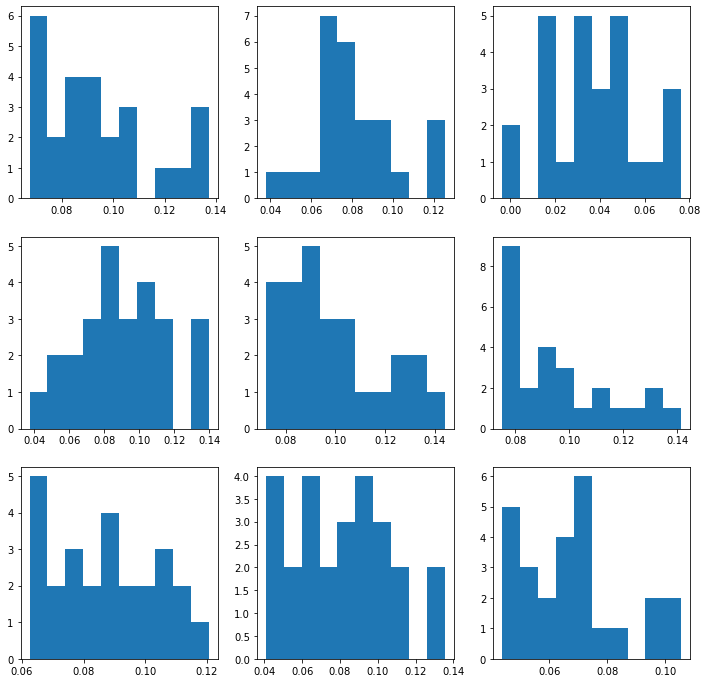

In [169]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
didx = 2

for i in range(r2.shape[-3]):
    a = ax[np.unravel_index(i, (3, 3))]
    a.hist(np.mean(r2[:, :, didx, i, 1, 4] - r2[:, :, didx, i, 0, 4], axis=1).ravel())

In [170]:
# Substantial across the entire reach? You can run statistical tests

In [176]:
len(msel[0])

26

In [174]:
msel[0][0].shape

(1, 5, 9, 2, 2)

In [182]:
np.array(msel[0][0][0, 0, 0, 0, 0]).shape

(357, 6)

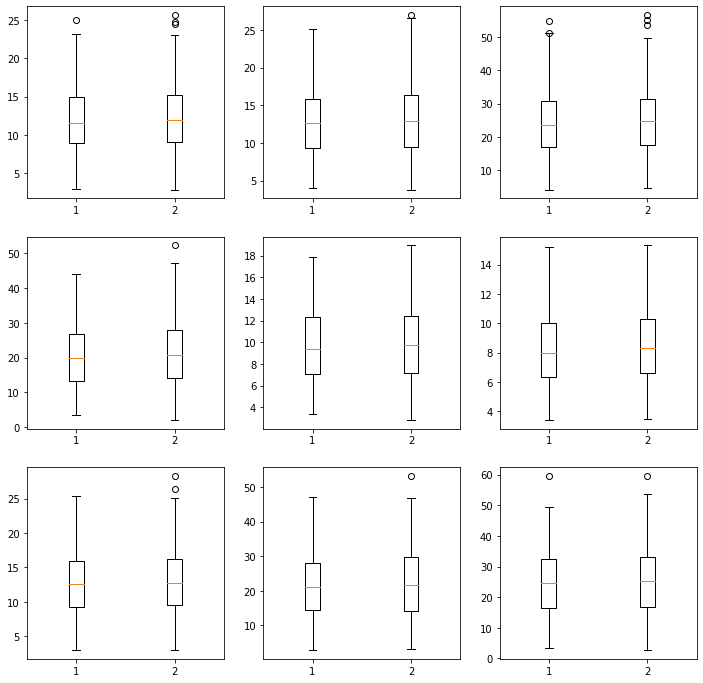

In [190]:
# Fix the fold, data file, dimension and plot boxplots of the MSE
fold_idx = 2
didix = 10
dimidx = 3
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(r2.shape[-3]):
    a = ax[np.unravel_index(i, (3, 3))]
    a.boxplot([np.linalg.norm(np.array(msel[fold_idx][didx][0, dimidx, i, 0, 0])[:, 0:2], axis=-1),
              np.linalg.norm(np.array(msel[fold_idx][didx][0, dimidx, i, 1, 0])[:, 0:2], axis=-1)])

In [192]:
# Let's collect indices corresponding to
# single velocity peak reaches (already done)
# Straightest reaches 
# Straightest reaches
# Reach distance
# Reach orientation
# Curved reaches
# Reach time
# Reach error
# Error threhold

# The corresponding analysis has to be re-run isolating thos ereaches only

### Windowing according to reach velocity

In [245]:
dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

Processing spikes


100%|██████████| 1/1 [00:20<00:00, 20.51s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [271]:
dat.keys()

dict_keys(['spike_rates', 'behavior', 'target', 'time', 'vel', 'target_pairs', 'transition_times', 'straight_dev', 'target_pair_error', 'transition_orientation'])

In [264]:
dat['target_pairs'][0]

(array([-51.25     ,  32.1428566]), array([-19.375    ,  80.7142868]))

In [266]:
l = np.array([np.linalg.norm(np.array(dat['target_pairs'][i])[1, :] - np.array(dat['target_pairs'][i])[0, :]) 
              for i in range(len(dat['target_pairs']))])

(array([ 63., 137., 142., 161., 116.,  99.,  66.,  41.,  29.,   6.]),
 array([  0.40544247,  19.37147603,  38.33750959,  57.30354316,
         76.26957672,  95.23561028, 114.20164384, 133.1676774 ,
        152.13371096, 171.09974453, 190.06577809]),
 <BarContainer object of 10 artists>)

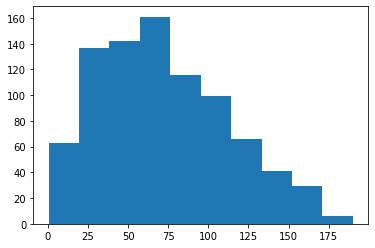

In [270]:
plt.hist(l)

In [258]:
np.squeeze(np.argwhere(x > 5))

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49])

In [254]:
x = np.linspace(0,10)

In [19]:
atype1 = glob.glob('/home/akumar/nse/neural_control/analysis_scripts/atype1*.npz')

In [20]:
r2l = [[] for f in range(5)]
msel = [[] for f in range(5)]
dindices = [[] for f in range(5)]
for f in atype1:
    dat = np.load(f, allow_pickle=True)
    fidx = int(f.split('fold')[1].split('.npz')[0])
    didx = int(f.split('didx')[1].split('_')[0])

    r2l[fidx].append(dat['r2'][np.newaxis])
    msel[fidx].append(dat['mse'][np.newaxis])
    dindices[fidx].append(didx)

In [21]:
complete_didx = set(range(28))
for i in range(5):
    complete_didx = complete_didx.intersection(set(dindices[i]))

complete_didx = list(complete_didx)
complete_didx_loc = [[] for i in range(5)]
for i in range(5):
    for idx in complete_didx:
        complete_didx_loc[i].append(dindices[i].index(idx))    

In [22]:
r2 = np.squeeze(np.transpose(np.array([np.array(r)[complete_didx_loc[i]] for i, r in enumerate(r2l)]), (1, 0, 2, 3, 4, 5, 6)))

In [25]:
r2.shape

(16, 5, 5, 6, 2, 6)

In [32]:
len(complete_didx_loc[0])

16

In [39]:
# Mse has shape (fold, dims, windows, methods, train/test)

In [38]:
len(msel[0][0][0, 1, 0, 0, 0])

129

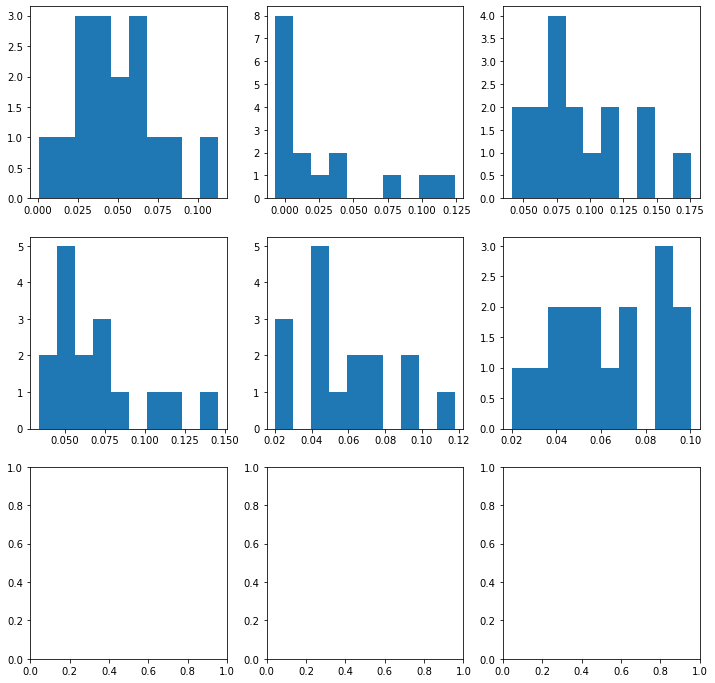

In [40]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
didx = 2

for i in range(r2.shape[-3]):
    a = ax[np.unravel_index(i, (3, 3))]
    a.hist(np.mean(r2[:, :, didx, i, 1, 1] - r2[:, :, didx, i, 0, 1], axis=1).ravel())

In [ ]:
# There might be some signal here, make sure to check for some minimum number of reaches

### First run

In [272]:
import sys
sys.path.append('/home/akumar/nse/neural_control/analysis_scripts')

In [273]:
from decodingvt import gen_run

In [352]:
gen_run('/home/akumar/nse/neural_control/analysis_scripts/run.sh', [0], np.arange(28), [(1., 'le'), (0.75, 'ge'), (0.5, 'ge'), (0.25, 'le')],
        [(0, 0, 'le'), (1, 0.75, 'ge'), (1, 0.5, 'le'), (1, 0.5, 'ge'), (1, 0.25, 'le'), 
         (3, 0.5, 'le'), (3, 0.5, 'ge'), (3, 0.25, 'le'), (4, 1, 'eq'), (4, 2, 'eq'), (4, 2, 'gt')])

In [279]:
fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvt/*.dat')

In [284]:
# filter params were not saved correctly in this run. Fortunately, we can still back out what is needed from the filter string

[autoreload of decodingvt failed: Traceback (most recent call last):
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_remo

In [286]:
fls[0].split('_')[4:]

['rf', '3', 'op', 'le', 'q', '50', 'et', '100', 'eop', 'le.dat']

In [305]:
fls[0]

'/home/akumar/nse/neural_control/data/decodingvt/atype0_didx0_widx0_rf_3_op_le_q_50_et_100_eop_le.dat'

In [309]:
fls[0].split('didx')[1].split('_')[0]

'0'

In [310]:
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    widx = int(fl.split('widx')[1].split('_')[0])
    s = fl.split('_')[4:]
    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-1].split('.dat')[0]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        mse = pickle.load(f)
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['mse'] = mse
    result['error_filter'] = error_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['widx'] = widx
    for k, v in filter_params.items():
        result[k] = v
    rl.append(result)

In [311]:
df = pd.DataFrame(rl)

In [300]:
np.unique(df['error_thresh'].values)

array([0.25, 0.5 , 0.75, 1.  ])

In [315]:
df.iloc[0]['r2'].shape

(4, 1, 2, 6)

In [334]:
df_ = apply_df_filters(df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le')

In [349]:
# Plots:
# For a fixed dimensionality, take the delta r2 across the data files for the different windows. There is a separate plot to be made here for
# each combination of error and reach filter parameters. 

error_filts = [(1., 'le'), (0.75, 'le'), (0.75, 'ge'), (0.5, 'le'), (0.5, 'ge'), (0.25, 'le')]
reach_filts =  [(0, 0, 'le'), (1, 0.75, 'le'), (1, 0.75, 'ge'), (1, 0.5, 'le'), (1, 0.5, 'ge'), (1, 0.25, 'le'), 
                (2, 0.5, 'le'), (2, 0.5, 'ge'), (2, 0.25, 'le'), (3, 0.5, 'le'), (3, 0.5, 'ge'), (3, 0.25, 'le'),
                (4, 2, 'eq'), (4, 2, 'gt')]

windows = [(0, 20), (-10, 10), (-5, 5), (0, 10), (0, 30), (-20, 20), (-20, 0), (15, 30), (10, 20)]

# To facillitate comparison, we pull out the delta r2 for the baseline and co-plot
df_ = apply_df_filters(df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le')
baseline_r2 = []
for j in range(5):
    d = apply_df_filters(df_, widx=j)
    if d.shape[0] == 0:
        continue

    r2 = []
    for k in range(d.shape[0]):
        r2.append(d.iloc[k]['r2'])
    r2 = np.squeeze(np.array(r2))
    delta_r2 = r2[:,:,1,1] - r2[:,:,0,1]
    baseline_r2.append(delta_r2)

for comb in tqdm(itertools.product(error_filts, reach_filts)):
    
    error_thresh = comb[0][0]
    error_op = comb[0][1]
    filter_type = comb[1][0]
    q = comb[1][1]
    op = comb[1][2]

    df_ = apply_df_filters(df, error_thresh=error_thresh, error_op=error_op, filter_type=filter_type, q=q, op=op)
    
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    for j in range(5):
        a = ax[np.unravel_index(j, (2, 3))]
        d = apply_df_filters(df_, widx=j)
        if d.shape[0] == 0:
            continue

        r2 = []
        for k in range(d.shape[0]):
            r2.append(d.iloc[k]['r2'])
        r2 = np.squeeze(np.array(r2))
        delta_r2 = r2[:,:,1,1] - r2[:,:,0,1]

        # r2 now has shape (data_files, dimidx, methods, pos + vel + acc for train/test)
        # Plot a boxplot of the delta r2 for velocity across the data files for the 4 different dimensionalities
        a.boxplot(delta_r2)
        a.boxplot(baseline_r2[j], boxprops=dict(color='red', alpha=0.25), capprops=dict(color='red',alpha=0.25), flierprops=dict(color='r', markeredgecolor='r'))
        #a.set_xticklabels(['dim=%d' % dim for dim in np.array([6, 10, 15, 20])])
        a.set_title(tuple(d.iloc[0]['window']))
        a.set_ylim([-0.2, 0.25])
    fig.suptitle('Filter Type %d, q %2f op %s, Error Thresh %2f, Error op %s' % (filter_type, q, op, error_thresh, error_op))
    savestr = 'rf_%d_op_%s_q_%d_et_%d_eop_%s' % (filter_type, op, int(100*q),
                                                int(100*error_thresh), error_op)
    fig.savefig('/home/akumar/nse/neural_control/figs/decodingvt/%s.png' % savestr, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

84it [00:45,  1.85it/s]


In [344]:
baseline_r2[0][0].shape

(5, 4)

### Full run

In [63]:
fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvtfull/*.dat')

[autoreload of decoders failed: Traceback (most recent call last):
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/akumar/anaconda3/envs/dyn/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_remove

In [8]:
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    widx = int(fl.split('widx')[1].split('_')[0])
    s = fl.split('_')[4:]
    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-1].split('.dat')[0]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        mse = pickle.load(f)
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['mse'] = mse
    result['error_filter'] = error_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['widx'] = widx
    for k, v in filter_params.items():
        result[k] = v
    rl.append(result)

In [9]:
df = pd.DataFrame(rl)

In [363]:
# Plots:
# For a fixed dimensionality, take the delta r2 across the data files for the different windows. There is a separate plot to be made here for
# each combination of error and reach filter parameters. 

error_filts = [(1., 'le'), (0.75, 'ge'), (0.5, 'ge'), (0.25, 'le')]
reach_filts =   [(0, 0, 'le'), (1, 0.75, 'ge'), (1, 0.5, 'le'), (1, 0.5, 'ge'), (1, 0.25, 'le'), 
                 (3, 0.5, 'le'), (3, 0.5, 'ge'), (3, 0.25, 'le'), (4, 1, 'eq'), (4, 2, 'eq'), (4, 2, 'gt')]

windows = [(-5, 5), (0, 10), (-10, 0), (10, 20), (20, 30), (30, 40), (-8, 2), (5, 15)]

# To facillitate comparison, we pull out the delta r2 for the baseline and co-plot
df_ = apply_df_filters(df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le')
baseline_r2 = []
for j in range(len(windows)):
    d = apply_df_filters(df_, widx=j)
    if d.shape[0] == 0:
        continue

    r2 = []
    for k in range(d.shape[0]):
        r2.append(d.iloc[k]['r2'])
    r2 = np.squeeze(np.array(r2))
    delta_r2 = r2[:,:,1,1] - r2[:,:,0,1]
    baseline_r2.append(delta_r2)

for comb in tqdm(itertools.product(error_filts, reach_filts)):
    
    error_thresh = comb[0][0]
    error_op = comb[0][1]
    filter_type = comb[1][0]
    q = comb[1][1]
    op = comb[1][2]

    df_ = apply_df_filters(df, error_thresh=error_thresh, error_op=error_op, filter_type=filter_type, q=q, op=op)
    
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    for j in range(len(windows)):
        a = ax[np.unravel_index(j, (3, 3))]
        d = apply_df_filters(df_, widx=j)
        if d.shape[0] == 0:
            continue

        r2 = []
        for k in range(d.shape[0]):
            r2.append(d.iloc[k]['r2'])
        r2 = np.squeeze(np.array(r2))
        delta_r2 = r2[:,:,1,1] - r2[:,:,0,1]

        # r2 now has shape (data_files, dimidx, methods, pos + vel + acc for train/test)
        # Plot a boxplot of the delta r2 for velocity across the data files for the 4 different dimensionalities
        a.boxplot(delta_r2)
        a.boxplot(baseline_r2[j], boxprops=dict(color='red', alpha=0.25), capprops=dict(color='red',alpha=0.25), flierprops=dict(color='r', markeredgecolor='r'))
        #a.set_xticklabels(['dim=%d' % dim for dim in np.array([6, 10, 15, 20])])
        a.set_title(tuple(d.iloc[0]['window']))
        a.set_ylim([-0.2, 0.25])

    fig.suptitle('Filter Type %d, q %2f op %s, Error Thresh %2f, Error op %s' % (filter_type, q, op, error_thresh, error_op))
    savestr = 'rf_%d_op_%s_q_%d_et_%d_eop_%s' % (filter_type, op, int(100*q),
                                               int(100*error_thresh), error_op)
    fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtfull/%s.png' % savestr, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

44it [00:38,  1.15it/s]


In [365]:
d.iloc[0]['r2'].shape

(4, 1, 2, 6)

In [385]:
window_centers

array([ 0.,  5., -5., 15., 25., 35., -3., 10.])

In [41]:
dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [49]:
windows = [(-5, 5), (0, 10), (-10, 0), (10, 20), (20, 30), (30, 40), (-8, 2), (5, 15)]
dimvals = np.array([6, 10, 15, 20])
window_centers = np.array([np.mean(w) for w in windows])     


/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

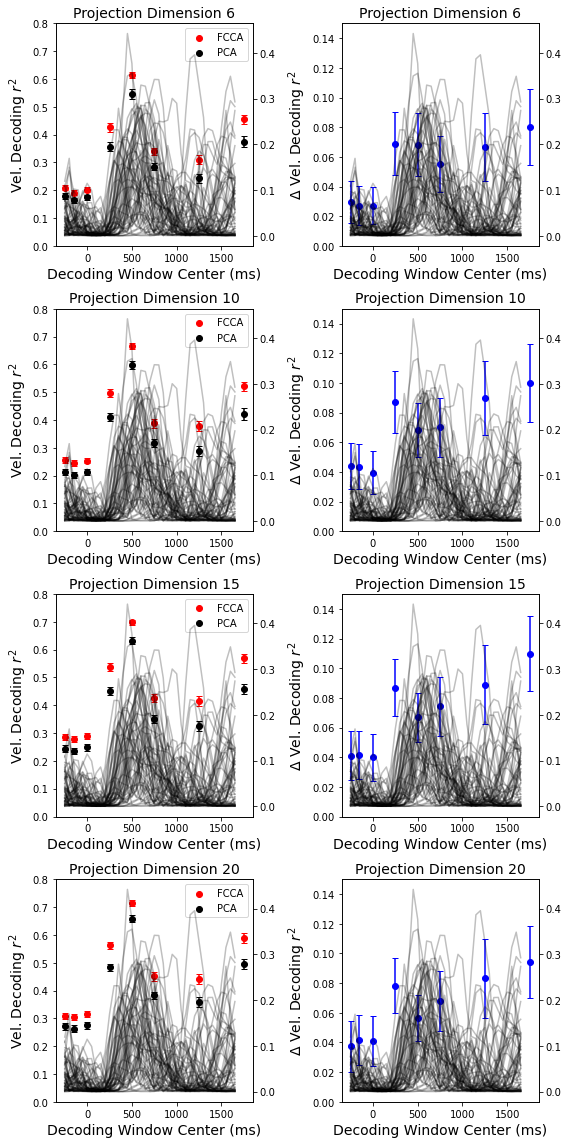

In [57]:
# First, looking at the overall trend. For each dimensionality, plot the decoding spread for each method as well as the difference as a function of the time of window center
fig, ax = plt.subplots(4, 2, figsize=(8, 16))

for i in range(4):
    df_ = apply_df_filters(df, error_thresh=1, error_op='le', filter_type=0, q=0, op='le')
    window_centers = np.array([np.mean(w) for w in windows])     

    r2f = []
    r2p = []
    for j in range(len(windows)):
        d = apply_df_filters(df_, widx=j)

        if d.shape[0] == 0:
            continue

        r2 = []
        for k in range(d.shape[0]):
            r2.append(np.squeeze(d.iloc[k]['r2'][i]))

        r2 = np.array(r2)
        r2f.append(r2[:, 1,1])
        r2p.append(r2[:, 0,1])

    r2f = np.array(r2f)
    r2p = np.array(r2p)

    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r')
    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k')

    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2f], color='r')
    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2p], color='k')


    ax[i, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], [np.sqrt(np.var(r1) + np.var(r2))/np.sqrt(r1.size) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b')
    ax[i, 1].scatter(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='b')

    ax[i, 0].set_ylim([0, 0.8])
    ax[i, 1].set_ylim([0, 0.15])
    ax[i, 0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 0].set_xlabel('Decoding Window Center (ms)', fontsize=14)

    ax[i, 1].set_xlabel('Decoding Window Center (ms)', fontsize=14)


    ax[i,  0].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)
    ax[i,  1].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)

    ax[i, 0].legend(['FCCA', 'PCA'])
    # ax[i, 1].plot(window_centers, r2f)
    # ax[i, 1].plot(window_centers, r2p)

    a = ax[i, 0].twinx()
    a2 = ax[i, 1].twinx()
    
    for tt in dat['transition_times'][::5]:
        vel = np.linalg.norm(np.diff(dat['behavior'][tt[0] - 5:tt[0] + 35], axis=0), axis=1)/(1e3 * 0.05)
        a.plot(50 * np.arange(-5, 34), vel, color='k', alpha=0.25)
        a2.plot(50 * np.arange(-5, 34), vel, color='k', alpha=0.25)
        
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/overall.pdf', bbox_inches='tight', pad_inches=0)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

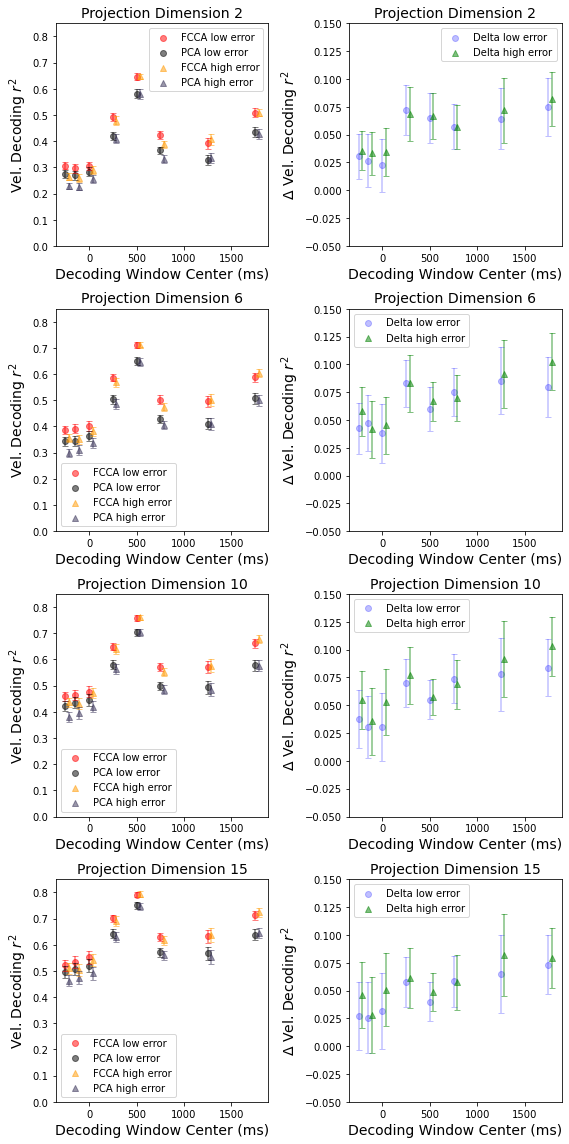

In [423]:
# Next, subdivide by low error reaches and high error eaches. Plot examples of the reaches in the 2 categories
# First, looking at the overall trend. For each dimensionality, plot the decoding spread for each method as well as the difference as a function of the time of window center
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i in range(4):
    df_ = apply_df_filters(df, error_thresh=0.25, error_op='le', filter_type=0, q=0, op='le')
    window_centers = np.array([np.mean(w) for w in windows])     
    r2f = []
    r2p = []
    for j in range(len(windows)):
        d = apply_df_filters(df_, widx=j)

        if d.shape[0] == 0:
            continue

        r2 = []
        for k in range(d.shape[0]):
            r2.append(np.squeeze(d.iloc[k]['r2'][i]))

        r2 = np.array(r2)
        r2f.append(r2[:, 1,1])
        r2p.append(r2[:, 0,1])

    r2f = np.array(r2f)
    r2p = np.array(r2p)

    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', alpha=0.5)
    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', alpha=0.5)

    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2f], color='r', alpha=0.5)
    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2p], color='k', alpha=0.5)


    ax[i, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], [np.sqrt(np.var(r1) + np.var(r2))/np.sqrt(r1.size) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b', alpha=0.25)
    ax[i, 1].scatter(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='b', alpha=0.25)

    df_ = apply_df_filters(df, error_thresh=0.75, error_op='ge', filter_type=0, q=0, op='le')
    window_centers = np.array([np.mean(w) for w in windows])     
    r2f = []
    r2p = []
    for j in range(len(windows)):
        d = apply_df_filters(df_, widx=j)

        if d.shape[0] == 0:
            continue

        r2 = []
        for k in range(d.shape[0]):
            r2.append(np.squeeze(d.iloc[k]['r2'][i]))

        r2 = np.array(r2)
        r2f.append(r2[:, 1,1])
        r2p.append(r2[:, 0,1])

    r2f = np.array(r2f)
    r2p = np.array(r2p)

    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='#ff9a03', alpha=0.5)
    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='#373157', alpha=0.5)

    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], color='#ff9a03', marker='^', alpha=0.5)
    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], color='#373157', marker='^', alpha=0.5)


    ax[i, 1].errorbar(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], [np.sqrt(np.var(r1) + np.var(r2))/np.sqrt(r1.size) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='g', alpha=0.5)
    ax[i, 1].scatter(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='g', alpha=0.5, marker='^')

    ax[i, 0].set_ylim([0, 0.85])
    ax[i, 1].set_ylim([-0.05, 0.15])
    ax[i, 0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
    ax[i, 1].set_xlabel('Decoding Window Center (ms)', fontsize=14)

    ax[i,  0].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)
    ax[i,  1].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)

    ax[i, 0].legend(['FCCA low error', 'PCA low error', 'FCCA high error', 'PCA high error'])
    ax[i, 1].legend(['Delta low error', 'Delta high error'])


    # ax[i, 1].plot(window_centers, r2f)
    # ax[i, 1].plot(window_centers, r2p)
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/highvlowerror.pdf', bbox_inches='tight', pad_inches=0)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

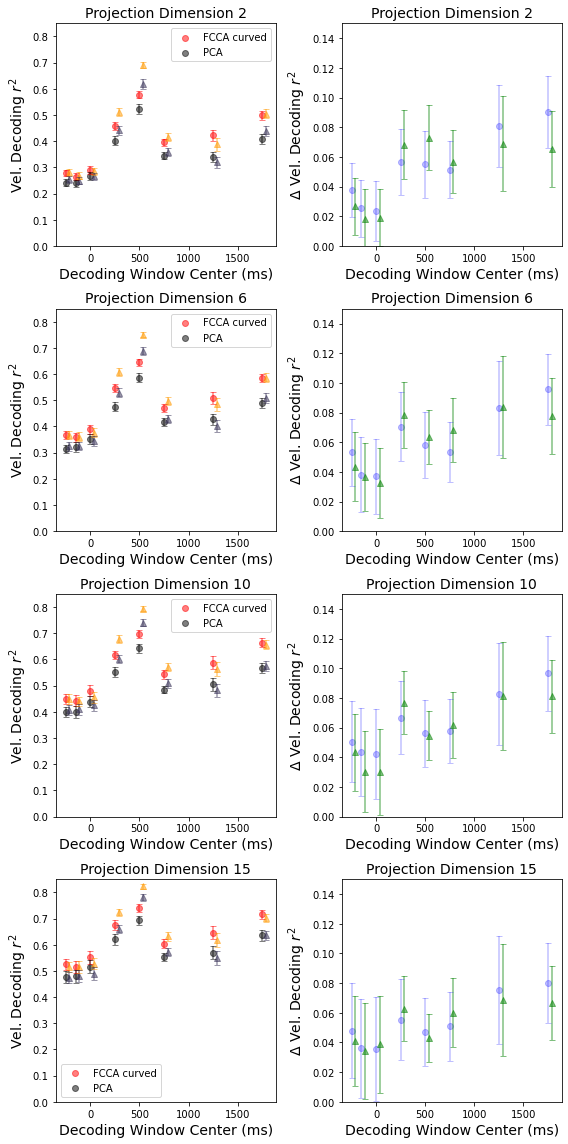

In [418]:
# Next, the 
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i in range(4):
    df_ = apply_df_filters(df, error_thresh=1, error_op='le', filter_type=1, q=0.75, op='ge')
    window_centers = np.array([np.mean(w) for w in windows])     
    r2f = []
    r2p = []
    for j in range(len(windows)):
        d = apply_df_filters(df_, widx=j)

        if d.shape[0] == 0:
            continue

        r2 = []
        for k in range(d.shape[0]):
            r2.append(np.squeeze(d.iloc[k]['r2'][i]))

        r2 = np.array(r2)
        r2f.append(r2[:, 1,1])
        r2p.append(r2[:, 0,1])

    r2f = np.array(r2f)
    r2p = np.array(r2p)

    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', alpha=0.5)
    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', alpha=0.5)

    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2f], color='r', alpha=0.5)
    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2p], color='k', alpha=0.5)


    ax[i, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], [np.sqrt(np.var(r1) + np.var(r2))/np.sqrt(r1.size) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b', alpha=0.25)
    ax[i, 1].scatter(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='b', alpha=0.25)

    df_ = apply_df_filters(df, error_thresh=1, error_op='le', filter_type=1, q=0.25, op='le')
    window_centers = np.array([np.mean(w) for w in windows])     
    r2f = []
    r2p = []
    for j in range(len(windows)):
        d = apply_df_filters(df_, widx=j)

        if d.shape[0] == 0:
            continue

        r2 = []
        for k in range(d.shape[0]):
            r2.append(np.squeeze(d.iloc[k]['r2'][i]))

        r2 = np.array(r2)
        r2f.append(r2[:, 1,1])
        r2p.append(r2[:, 0,1])

    r2f = np.array(r2f)
    r2p = np.array(r2p)

    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='#ff9a03', alpha=0.5)
    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='#373157', alpha=0.5)

    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], color='#ff9a03', marker='^', alpha=0.5)
    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], color='#373157', marker='^', alpha=0.5)


    ax[i, 1].errorbar(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], [np.sqrt(np.var(r1) + np.var(r2))/np.sqrt(r1.size) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='g', alpha=0.5)
    ax[i, 1].scatter(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='g', alpha=0.5, marker='^')

    ax[i, 0].set_ylim([0, 0.85])
    ax[i, 1].set_ylim([0, 0.15])
    ax[i, 0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
    ax[i, 1].set_xlabel('Decoding Window Center (ms)', fontsize=14)

    ax[i,  0].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)
    ax[i,  1].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)

    ax[i, 0].legend(['FCCA curved', 'PCA'])
    

    # ax[i, 1].plot(window_centers, r2f)
    # ax[i, 1].plot(window_centers, r2p)
fig.tight_layout()


/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you

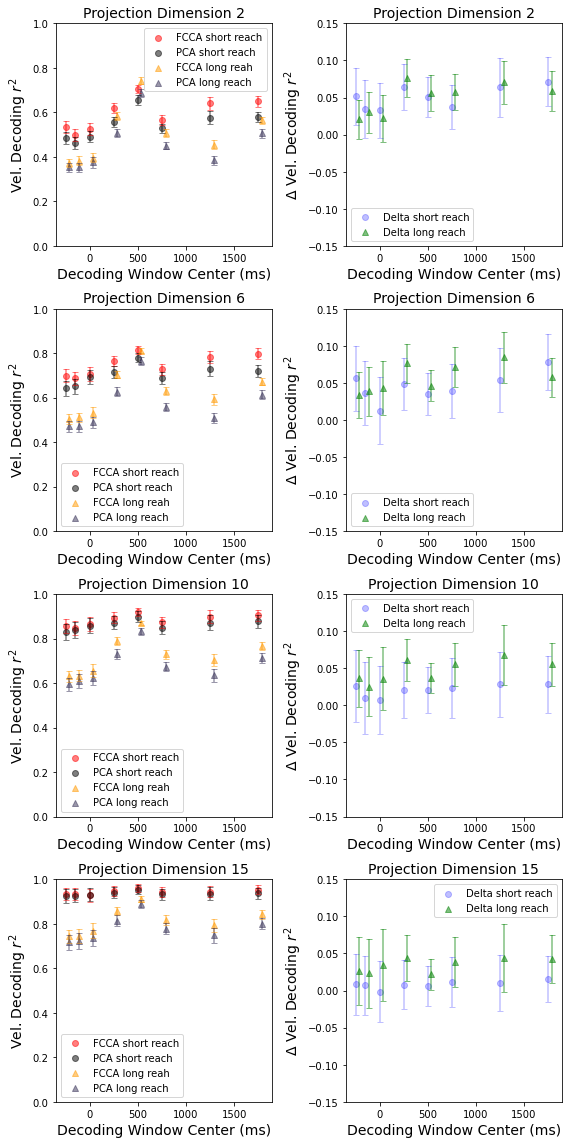

In [425]:
# Next, reach length
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i in range(4):
    df_ = apply_df_filters(df, error_thresh=0.25, error_op='le', filter_type=3, q=0.25, op='le')
    window_centers = np.array([np.mean(w) for w in windows])     
    r2f = []
    r2p = []
    for j in range(len(windows)):
        d = apply_df_filters(df_, widx=j)

        if d.shape[0] == 0:
            continue

        r2 = []
        for k in range(d.shape[0]):
            r2.append(np.squeeze(d.iloc[k]['r2'][i]))

        r2 = np.array(r2)
        r2f.append(r2[:, 1,1])
        r2p.append(r2[:, 0,1])

    r2f = np.array(r2f)
    r2p = np.array(r2p)

    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='r', alpha=0.5)
    ax[i, 0].errorbar(50 * window_centers, [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='k', alpha=0.5)

    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2f], color='r', alpha=0.5)
    ax[i, 0].scatter(50 * window_centers, [np.mean(r) for r in r2p], color='k', alpha=0.5)


    ax[i, 1].errorbar(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], [np.sqrt(np.var(r1) + np.var(r2))/np.sqrt(r1.size) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='b', alpha=0.25)
    ax[i, 1].scatter(50 * window_centers, [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='b', alpha=0.25)

    df_ = apply_df_filters(df, error_thresh=0.25, error_op='le', filter_type=3, q=0.5, op='ge')
    window_centers = np.array([np.mean(w) for w in windows])     
    r2f = []
    r2p = []
    for j in range(len(windows)):
        d = apply_df_filters(df_, widx=j)

        if d.shape[0] == 0:
            continue

        r2 = []
        for k in range(d.shape[0]):
            r2.append(np.squeeze(d.iloc[k]['r2'][i]))

        r2 = np.array(r2)
        r2f.append(r2[:, 1,1])
        r2p.append(r2[:, 0,1])

    r2f = np.array(r2f)
    r2p = np.array(r2p)

    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], [np.std(r)/np.sqrt(r.size) for r in r2f], linestyle='', capsize=3, color='#ff9a03', alpha=0.5)
    ax[i, 0].errorbar(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], [np.std(r)/np.sqrt(r.size) for r in r2p], linestyle='', capsize=3, color='#373157', alpha=0.5)

    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2f], color='#ff9a03', marker='^', alpha=0.5)
    ax[i, 0].scatter(50 * (window_centers + 0.75), [np.mean(r) for r in r2p], color='#373157', marker='^', alpha=0.5)


    ax[i, 1].errorbar(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], [np.sqrt(np.var(r1) + np.var(r2))/np.sqrt(r1.size) for (r1, r2) in zip(r2f, r2p)], linestyle='', capsize=3, color='g', alpha=0.5)
    ax[i, 1].scatter(50 * (window_centers + 0.75), [np.mean(r1 - r2) for (r1, r2) in zip(r2f, r2p)], color='g', alpha=0.5, marker='^')

    ax[i, 0].set_ylim([0, 1])
    ax[i, 1].set_ylim([-0.15, 0.15])
    ax[i, 0].set_ylabel('Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 1].set_ylabel(r'$\Delta$'  + ' Vel. Decoding ' + r'$r^2$', fontsize=14)
    ax[i, 0].set_xlabel('Decoding Window Center (ms)', fontsize=14)
    ax[i, 1].set_xlabel('Decoding Window Center (ms)', fontsize=14)

    ax[i,  0].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)
    ax[i,  1].set_title('Projection Dimension %d' % dimvals[i], fontsize=14)

    ax[i, 0].legend(['FCCA short reach', 'PCA short reach', 'FCCA long reah', 'PCA long reach'])
    ax[i, 1].legend(['Delta short reach', 'Delta long reach'])

    # ax[i, 1].plot(window_centers, r2f)
    # ax[i, 1].plot(window_centers, r2p)
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/shortvlong.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Long vs. short reaches

In [10]:
df1 = apply_df_filters(df, error_thresh=0.25, error_op='le', filter_type=3, q=0.25, op='le', widx=0, didx=2)
df2 = apply_df_filters(df, error_thresh=0.25, error_op='le', filter_type=3, q=0.5, op='ge', widx=0, didx=2)

In [11]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df1 = pickle.load(f)
data_files = np.unique(sabes_df1['data_file'].values)
data_file = data_files[df1.iloc[0]['didx']]

In [12]:
dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)    
dat = reach_segment_sabes(dat, start_times[data_file.split('.mat')[0]])

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.12s/it]
/home/akumar/nse/neural_control/segmentation.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [14]:
z1 = []
z2 = []

# reaches1 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] >= high_error)[:, 0]]
# reaches2 = np.array(dat['transition_times'])[np.argwhere(dat['target_pair_error'] <= low_error)[:, 0]]
reaches1 = np.array(dat['transition_times'])[df1.iloc[0]['error_filter']]
reaches1 = reaches1[df1.iloc[0]['reach_filter']]

reaches2 = np.array(dat['transition_times'])[df2.iloc[0]['error_filter']]
reaches2 = reaches2[df2.iloc[0]['reach_filter']]

for i in range(reaches1.shape[0]):
    z1.append(dat['behavior'][reaches1[i, 0]:reaches1[i, 1]])
    z2.append(dat['behavior'][reaches2[i, 0]:reaches2[i, 1]])

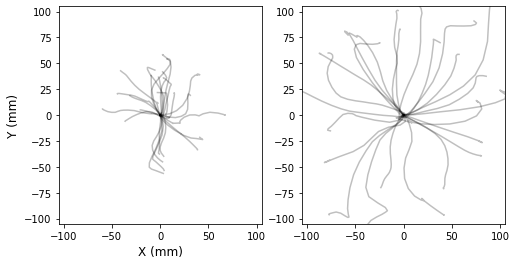

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(reaches1.shape[0]):
    z = z1[i] - z1[i][0]
    ax[0].plot(z[:, 0], z[:, 1], color='k', alpha=0.25)
    z = z2[i] - z2[i][0]
    ax[1].plot(z[:, 0], z[:, 1], color='k', alpha=0.25)
    ax[0].set_xlim([-105, 105])
    ax[0].set_ylim([-105, 105])    

    ax[1].set_xlim([-105, 105])
    ax[1].set_ylim([-105, 105])    
    ax[0].set_xlabel('X (mm)', fontsize=12)
    ax[0].set_ylabel('Y (mm)', fontsize=12)
fig.savefig('/home/akumar/nse/neural_control/figs/decodingvtsummary/longvshortreaches.pdf')

In [59]:
from tqdm import tqdm
from dca_research.lqg import LQGComponentsAnalysis as LQGCA
from sklearn.decomposition import PCA

In [61]:
# Fit FCCA and PCA on d = 2, 6, 10, 15 without cross validation for use in decoding v t
dimvals = [2, 6, 10, 15]
rl = []
for i, data_file in tqdm(enumerate(data_files)):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])

    pcamodel = PCA().fit(X)

    for j, dim in enumerate(dimvals):
        lqgmodel = LQGCA(T=3, loss_type='trace', n_init=5)
        lqgmodel.fit(X, d=dim)

        result = {}
        result['data_file'] = data_file
        result['dim'] = dim
        result['lqgcoef'] = lqgmodel.coef_
        result['pcacoef'] = pcamodel.components_.T[:, 0:dim]

        rl.append(result)

0it [00:00, ?it/s]

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.53s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
1it [00:21, 21.29s/it]

Processing spikes


100%|██████████| 1/1 [00:20<00:00, 20.09s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
2it [00:49, 25.23s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
3it [00:58, 17.69s/it]

Processing spikes


100%|██████████| 1/1 [00:27<00:00, 27.54s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
4it [01:34, 25.03s/it]

Processing spikes


100%|██████████| 1/1 [00:11<00:00, 11.82s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
5it [01:51, 22.04s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
6it [01:58, 17.05s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
7it [02:05, 13.71s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
8it [02:13, 12.05s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.30s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
9it [02:22, 10.90s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
10it [02:29,  9.76s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
11it [02:38,  9.64s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  4.00s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
12it [02:47,  9.29s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.51s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
13it [02:57,  9.57s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
14it [03:06,  9.32s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.29s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
15it [03:14,  9.11s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.08s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
16it [03:22,  8.82s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.94s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
17it [03:30,  8.61s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
18it [03:39,  8.65s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.12s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
19it [03:48,  8.59s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.79s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
20it [03:57,  8.96s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.11s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
21it [04:08,  9.54s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
22it [04:16,  8.98s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.61s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
23it [04:25,  9.08s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.70s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
24it [04:35,  9.20s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.14s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
25it [04:44,  9.14s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.80s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
26it [04:54,  9.53s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.00s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
27it [05:06, 10.06s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.69s/it]
/home/akumar/nse/DCA_research/dca_research/lqg.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cross_cov_mats = torch.tensor(cross_cov_mats)
28it [05:17, 11.33s/it]


In [62]:
with open('/home/akumar/nse/neural_control/data/sabes_dimreduc_nocv.dat', 'wb') as f:
    f.write(pickle.dumps(rl))

## Cleaned Up version

In [ ]:
# Note we made a modification to only consider end target error when filtering by error

In [65]:
import sys
sys.path.append('/home/akumar/nse/neural_control/analysis_scripts')
from decodingvt import gen_run

In [67]:
gen_run('/home/akumar/nse/neural_control/analysis_scripts/run.sh', np.arange(28), [(1., 'le'), (0.75, 'ge'), (0.5, 'ge'),(0.5, 'le'),(0.25, 'le')],
        [(0, 0, 'le'), (3, 0.5, 'le'), (3, 0.5, 'ge'), (3, 0.25, 'le'), (3, 0.75, 'ge')])

In [70]:
fls = glob.glob('/home/akumar/nse/neural_control/data/decodingvtfull/cleanedup/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[3:]

    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-1].split('.dat')[0]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        mse = pickle.load(f)
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['mse'] = mse
    result['error_filter'] = error_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = dim
    for k, v in filter_params.items():
        result[k] = v
    rl.append(result)
df = pd.DataFrame(rl)

> /tmp/ipykernel_15077/4095064540.py(9)<module>()
      7     s = fl.split('_')[4:]
      8     pdb.set_trace()
----> 9     filter_params = {}
     10     filter_params['error_thresh'] = float(s[7])/100
     11     filter_params['error_op'] = s[-1].split('.dat')[0]

['3', 'op', 'ge', 'q', '75', 'et', '50', 'eop', 'le.dat']
['/home/akumar/nse/neural', 'control/data/decodingvtfull/cleanedup/didx2', 'dim1', 'rf', '3', 'op', 'ge', 'q', '75', 'et', '50', 'eop', 'le.dat']
['/home/akumar/nse/neural', 'control/data/decodingvtfull/cleanedup/didx2', 'dim1', 'rf', '3', 'op', 'ge', 'q', '75', 'et', '50', 'eop', 'le.dat']


BdbQuit: 